# Prediciting high school graduation rate of a cohort based on holistic data of the student population and school.

What do variables about:
- the broader structure of a school
- the experience of previous cohorts
- the freshmen, sophomore and junior year experience of rising seniors
tell us about the graduating % of rising seniors?

Data was gathered from https://www.isbe.net/pages/illinois-state-report-card-data.aspx
I have collected end of year data for the following academic years:
- 2018/19
- 2017/18
- 2016/17
- 2015/16
- 2014/15
- 2013/14
- 2012/13

I will look at the following cohorts for training the data:

- Class of 2017
- Class of 2016

and follow them thru their 4 years of high school (grades 9-12)

I will run validation on 
- Class of 2018

My test set with be 
- Class of 2019

The goal is to predict the 4-year high school graduation rate for this cohort.

# Cleaning and exploring datasets for capstone project

Gathering the data for each of the academic years 2013 - 2017 involved downloading semi-colon separated .txt files, importing them into a spreadsheet, then matching the columns to headers that were recorded in a separate .xls file. While performing this task, I also selected feature set to use for this project.

I also added a column to every academic year to identify the cohort by their graduation year (e.g. 2018). 

I will create a matrix of the information for each cohort.

In [1]:
# import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

# import additional libraries
import pandasql as ps
from pandasql import sqldf

import statsmodels.api as sm
from statsmodels.formula.api import ols

# pysqldf lambda function
pysqldf = lambda q: sqldf(q, globals())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# eda function
def proj_eda(df): 
    eda_df = {}
    eda_df['null_sum'] = df.isnull().sum()
    eda_df['null_pct'] = df.isnull().mean()
    eda_df['dtypes'] = df.dtypes
    eda_df['count'] = df.count()
    eda_df['mean'] = df.mean()
    eda_df['median'] = df.median()
    eda_df['min'] = df.min()
    eda_df['max'] = df.max()
    
    return pd.DataFrame(eda_df)

In [3]:
def clean_col(df):

    df.columns = [x.lower()
                 .replace("-", " ")
                 .replace("  ", " ")
                 .replace(" ", "_")
                 .replace("__", "_")
                 .rstrip()
                 .replace("#", "number")
                 .replace("%", "percent") for x in df.columns]
    return df.columns.to_list()

In [4]:
# plot parameters
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 16

In [5]:
# heatmap function
def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    '''
    plt.figure(figsize=(10, 10))
    g = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='YlGnBu', 
                    cbar=False,
                    vmin=-1,
                    vmax=1)  
    return g

### Step 1
create a dataframe for each academic year for schools that serve grades 9 - 12.
This will include traditional high schools and some charter schools that serve grades in addition to 9 - 12. This may have an impact on features such as the total number of students in a school, attendance rate and I will have to be aware and make corrections if needed.

#### Class of 2019

In [6]:
df_19 = pd.read_excel('../../data/2019-Report-Card-Public-Data-Set.xlsx')
df_19.shape

(4738, 36)

In [7]:
clean_col(df_19)

['cohort',
 'rcdts',
 'type',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 '

In [8]:
# create query to return schools with grades 9-12

q1 = """SELECT * 
       FROM df_19
       WHERE grades_served LIKE "%12%";"""

hs_19 = pysqldf(q1)

In [9]:
hs_19.head()

,cohort,rcdts,type,school_name,district,city,county,district_type,district_size,school_type,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2019.0,010010010260001,School,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,...,None,None,86.8,2.0,68.8,68.8,95.6,NaN,NaN,NaN
1,2019.0,010010020260001,School,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,...,None,None,83.9,2.0,58.1,58.1,94.0,NaN,NaN,NaN
2,2019.0,010010030260001,School,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,...,None,None,83.3,2.0,75.0,73.3,94.9,NaN,NaN,NaN
3,2019.0,010010040260001,School,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,...,None,None,86.4,1.0,60.7,60.7,92.9,NaN,NaN,27.0
4,2019.0,010011720220003,School,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,...,None,None,86.4,2.0,67.7,65.7,74.9,68.0,127.0,126.0


#### Class of 2018

In [10]:
df_18 = pd.read_excel('../../data/2018-Report-Card-Public-Data-Set.xlsx', sheet_name="General")
df_18.shape

(4754, 36)

In [11]:
clean_col(df_18)

['cohort',
 'rcdts',
 'type',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 '

In [12]:
q2 = """SELECT * 
       FROM df_18
       WHERE grades_served LIKE "%12%";"""

hs_18 = pysqldf(q2)

In [13]:
hs_18.head()

,cohort,rcdts,type,school_name,district,city,county,district_type,district_size,school_type,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2018.0,010010010260001,School,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,...,None,None,90.6,2.0,81.5,81.5,100.0,NaN,NaN,NaN
1,2018.0,010010020260001,School,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,...,None,None,84.8,2.0,80.4,80.4,93.0,NaN,NaN,NaN
2,2018.0,010010030260001,School,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,...,None,None,83.7,1.0,75.0,75.0,94.0,NaN,NaN,NaN
3,2018.0,010010040260001,School,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,...,None,None,83.7,1.0,74.0,72.0,80.0,NaN,NaN,20.0
4,2018.0,010011720220003,School,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,...,None,None,81.9,3.0,68.9,68.2,51.0,109.0,110.0,148.0


In [14]:
hs_18.school_type

0      HIGH SCHOOL
1      HIGH SCHOOL
2      HIGH SCHOOL
3      HIGH SCHOOL
4      HIGH SCHOOL
          ...     
716    HIGH SCHOOL
717    HIGH SCHOOL
718    HIGH SCHOOL
719    HIGH SCHOOL
720    HIGH SCHOOL
Name: school_type, Length: 721, dtype: object

#### Class of 2017

In [15]:
df_17 = pd.read_excel('../../data/2017-Report-Card-Public-Data-Set_clean.xlsx')
df_17.shape

(3796, 35)

In [16]:
clean_col(df_17)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [17]:
q3 = """SELECT * 
       FROM df_17
       WHERE grades_served LIKE "%12%";"""

hs_17 = pysqldf(q3)

In [18]:
hs_17.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2017,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,10.1,"$36,294",87.5,2,66.7,66.7,84.6,0,0,0
1,2017,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,23.5,"$41,061",71.1,2,70.8,66.7,89.1,0,0,0
2,2017,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,12.8,"$45,975",71.4,2,73.2,64.3,89.1,0,0,0
3,2017,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,17.5,"$40,873",82.1,1,64.1,59,84.3,0,0,18
4,2017,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,9 10 11 12,...,28.5,"$41,946",77.4,2,69.8,65.1,63.1,93,122,125


In [19]:
hs_17.high_school_4_year_graduation_rate_total

0      91.4
1      87.2
2      96.8
3      90.2
4      88.7
       ... 
707    98.3
708    98.5
709    91.8
710    85.3
711    91.8
Name: high_school_4_year_graduation_rate_total, Length: 712, dtype: object

#### Class of 2016

In [20]:
df_16 = pd.read_excel('../../data/2016-Report-Card-Public-Data-Set_clean.xlsx')
df_16.shape

(3735, 35)

In [21]:
clean_col(df_16)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [22]:
q4 = """SELECT * 
       FROM df_16
       WHERE grades_served LIKE "%12%";"""

hs_16 = pysqldf(q4)

In [23]:
hs_16.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2016,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,8.4,"$34,801",None,3,65,65,77.8,0,0,0
1,2016,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,16.7,"$40,883",None,1,77.3,70.5,97.9,,,
2,2016,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,13.7,"$46,882",None,2,76.7,70,94.3,0,0,0
3,2016,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,15.6,"$40,823",None,1,63.6,60,84.4,0,0,21
4,2016,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,10 11 12,...,26.4,"$44,780",None,2,62.2,57.1,,144,161,157


#### Class of 2015


In [24]:
df_15 = pd.read_excel('../../data/2015-Report-Card-Public-Data-Set_clean.xlsx')
df_15.shape

(3764, 35)

In [25]:
clean_col(df_15)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [26]:
q5 = """SELECT * 
       FROM df_15
       WHERE grades_served LIKE "%12%";"""

hs_15 = pysqldf(q5)

In [27]:
hs_15.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2015,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,7.6,"$33,771",73.7,3,72.7,69.7,93,None,None,None
1,2015,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,17.2,"$41,447",74.1,1,81.6,77.6,97.4,None,None,None
2,2015,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,15.1,"$46,534",74.6,2,64.1,60.9,95.8,None,None,None
3,2015,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,14.4,"$40,549",82,1,69.8,69.8,71.7,None,None,None
4,2015,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,10 11 12,...,22.6,"$44,849",81.7,2,66.2,62.7,,None,None,None


#### Class of 2014

In [28]:
df_14 = pd.read_excel('../../data/2014-Report-Card-Public-Data-Set_clean.xlsx')
df_14.shape

(3794, 35)

In [29]:
clean_col(df_14)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [30]:
q6 = """SELECT * 
       FROM df_14
       WHERE grades_served LIKE "%12%";"""

hs_14 = pysqldf(q6)

In [31]:
hs_14.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2014,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,9.7,"$40,711",69.5,2,None,None,None,None,None,None
1,2014,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,14.8,"$40,764",86,1,None,None,None,None,None,None
2,2014,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,12.4,"$46,756",80,2,None,None,None,None,None,None
3,2014,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,13.4,"$40,744",81.7,1,None,None,None,None,None,None
4,2014,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,10 11 12,...,19.1,"$44,812",87.6,3,None,None,None,None,None,None


#### Class of 2013

In [32]:
df_13 = pd.read_excel('../../data/2013-Report-Card-Public-Data-Set_clean.xlsx')
df_13.shape

(3862, 35)

In [33]:
clean_col(df_13)

['cohort',
 'rcdts',
 'school_name',
 'district',
 'city',
 'county',
 'district_type',
 'district_size',
 'school_type',
 'grades_served',
 'percent_student_enrollment_white',
 'percent_student_enrollment_black_or_african_american',
 'percent_student_enrollment_hispanic_or_latino',
 'percent_student_enrollment_asian',
 'percent_student_enrollment_native_hawaiian_or_other_pacific_islander',
 'percent_student_enrollment_american_indian_or_alaska_native',
 'percent_student_enrollment_two_or_more_races',
 'number_student_enrollment',
 'total_number_of_school_days',
 'student_attendance_rate',
 'student_chronic_truancy_rate',
 'high_school_dropout_rate_total',
 'high_school_4_year_graduation_rate_total',
 'high_school_5_year_graduation_rate_total',
 'avg_class_size_high_school',
 'pupil_teacher_ratio_high_school',
 'teacher_avg_salary',
 'teacher_retention_rate',
 'principal_turnover_within_6_years',
 'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
 'percent_g

In [34]:
q7 = """SELECT * 
       FROM df_13
       WHERE grades_served LIKE "%12%";"""

hs_13 = pysqldf(q7)

In [35]:
hs_13.head()

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2013,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,SMALL,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
1,2013,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
2,2013,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
3,2013,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
4,2013,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,10 11 12,...,None,None,None,None,None,None,None,None,None,None


### Step 2
create a matrix where one row is the cohort of a school (e.g. cohort 2018 for school xxx1, cohort 2017 for xxx1, cohort 2018 for school yyy2, cohort 2017 for school yyy2).

In [36]:
columns_check= list(hs_13.columns)

dataframes_check = [hs_14, hs_15, hs_16, hs_17, hs_18]
missing = {}
for idx, dataframe in enumerate(dataframes_check):
    missing_columns = [x for x in columns_check if x not in dataframes_check[idx].columns]
    if missing_columns:
        missing[idx]=missing_columns

In [37]:
missing

{}

In [38]:
final_features=['cohort','rcdts','school_name','district','city','county','district_type', 'district_size',
                'school_type','grades_served','percent_student_enrollment_white',
                'percent_student_enrollment_black_or_african_american',
                'percent_student_enrollment_hispanic_or_latino','percent_student_enrollment_asian',
                'percent_student_enrollment_native_hawaiian_or_other_pacific_islander','percent_student_enrollment_american_indian_or_alaska_native','percent_student_enrollment_two_or_more_races',
                'number_student_enrollment','total_number_of_school_days','student_attendance_rate','student_chronic_truancy_rate',
                'high_school_dropout_rate_total','high_school_4_year_graduation_rate_total','high_school_5_year_graduation_rate_total',
                'avg_class_size_high_school','pupil_teacher_ratio_high_school','teacher_retention_rate',
                'principal_turnover_within_6_years','percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months',
                'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months','percent_9th_grade_on_track',
                'number_students_who_took_ap_classes_grade_10_total','number_students_who_took_ap_classes_grade_11_total',
                'number_students_who_took_ap_classes_grade_12_total']
final_features
all_dfs=[hs_13, hs_14, hs_15, hs_16, hs_17]
filtered_dfs=[]

for dataframe in all_dfs:
    filtered_dfs.append(dataframe[final_features])
    
merged_df = pd.concat(all_dfs) 

In [39]:
merged_df

,cohort,rcdts,school_name,district,city,county,district_type,district_size,school_type,grades_served,...,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,2013,10010010260001,Seymour High School,Payson CUSD 1,Payson,Adams,UNIT,SMALL,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
1,2013,10010020260001,Liberty High School,Liberty CUSD 2,Liberty,Adams,UNIT,MEDIUM,HIGH SCHOOL,7 8 9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
2,2013,10010030260001,Central High School,Central CUSD 3,Camp Point,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
3,2013,10010040260001,Unity High School,CUSD 4,Mendon,Adams,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,None,None,None,None,None,None,None,None,None,None
4,2013,10011720220003,Quincy Sr High School,Quincy SD 172,Quincy,Adams,UNIT,LARGE,HIGH SCHOOL,10 11 12,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,2017,560992100160002,Lincoln-Way East High School,Lincoln Way CHSD 210,Frankfort,Will,HIGH SCHOOL,LARGE,HIGH SCHOOL,9 10 11 12,...,20.9,"$86,214",79.6,1,88.9,86.9,96,230,398,441
708,2017,560992100160004,Lincoln Way West,Lincoln Way CHSD 210,New Lenox,Will,HIGH SCHOOL,LARGE,HIGH SCHOOL,9 10 11 12,...,20.9,"$86,214",82.6,1,88.7,86.5,93.7,151,280,237
709,2017,56099255U260001,Reed-Custer High School,Reed Custer CUSD 255U,Braidwood,Will,UNIT,MEDIUM,HIGH SCHOOL,9 10 11 12,...,15.9,"$56,732",86.2,1,60.8,56.7,90.8,0,3,16
710,2017,56099365U260007,Bolingbrook High School,Valley View CUSD 365U,Bolingbrook,Will,UNIT,LARGE,HIGH SCHOOL,9 10 11 12,...,20.7,"$61,068",88.6,5,67.4,63.1,87.3,55,230,184


### Step 3

Identify target variable - high_school_4_year_graduation_rate_total

features are the remaining 

In [40]:
proj_eda(merged_df)

,null_sum,null_pct,dtypes,count,mean,median,min,max
avg_class_size_high_school,0,0.000000,object,3403,NaN,NaN,,9.9
city,0,0.000000,object,3403,NaN,NaN,Abingdon,Zion
cohort,0,0.000000,int64,3403,2015.020276,2015.0,2013,2017
county,0,0.000000,object,3403,NaN,NaN,Adams,Woodford
district,0,0.000000,object,3403,NaN,NaN,A-C Central CUSD 262,Zion-Benton Twp HSD 126
district_size,0,0.000000,object,3403,NaN,NaN,LARGE,SMALL
district_type,0,0.000000,object,3403,NaN,NaN,HIGH SCHOOL,UNIT
grades_served,0,0.000000,object,3403,NaN,NaN,10 11 12,PK K 1 2 3 4 5 6 7 8 9 10 11 12
high_school_4_year_graduation_rate_total,0,0.000000,object,3403,NaN,NaN,,99.7
high_school_5_year_graduation_rate_total,0,0.000000,object,3403,NaN,NaN,,99.8


#### I need to change some of these columns from object to float



In [41]:
merged_df[['high_school_4_year_graduation_rate_total',
           'high_school_5_year_graduation_rate_total', 
           'avg_class_size_high_school', 'total_number_of_school_days',
           'student_attendance_rate','high_school_dropout_rate_total',
           'student_chronic_truancy_rate', 'pupil_teacher_ratio_high_school', 
           'teacher_avg_salary', 'teacher_retention_rate', 'principal_turnover_within_6_years', 
           'percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months', 
           'percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months', 
           'percent_9th_grade_on_track', 'number_students_who_took_ap_classes_grade_10_total', 
           'number_students_who_took_ap_classes_grade_11_total', 
           'number_students_who_took_ap_classes_grade_12_total'
          ]].apply(pd.to_numeric, downcast='float', errors='coerce')


,high_school_4_year_graduation_rate_total,high_school_5_year_graduation_rate_total,avg_class_size_high_school,total_number_of_school_days,student_attendance_rate,high_school_dropout_rate_total,student_chronic_truancy_rate,pupil_teacher_ratio_high_school,teacher_avg_salary,teacher_retention_rate,principal_turnover_within_6_years,percent_graduates_enrolled_in_a_postsecondary_institution_within_16_months,percent_graduates_enrolled_in_a_postsecondary_institution_within_12_months,percent_9th_grade_on_track,number_students_who_took_ap_classes_grade_10_total,number_students_who_took_ap_classes_grade_11_total,number_students_who_took_ap_classes_grade_12_total
0,86.800003,94.099998,11.100000,174.0,96.000000,1.4,2.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,90.699997,93.800003,29.500000,176.0,95.800003,0.5,1.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.900002,89.699997,12.700000,175.0,93.300003,0.0,5.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.099998,88.599998,10.900000,175.0,95.400002,0.5,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,88.199997,88.500000,20.100000,176.0,92.000000,4.6,12.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,98.300003,96.699997,23.600000,175.0,95.300003,0.1,0.200000,20.900000,NaN,79.599998,1.0,88.900002,86.900002,96.000000,230.0,398.0,441.0
708,98.500000,97.199997,23.700001,175.0,94.800003,0.2,0.400000,20.900000,NaN,82.599998,1.0,88.699997,86.500000,93.699997,151.0,280.0,237.0
709,91.800003,95.800003,15.300000,174.0,95.699997,1.7,3.700000,15.900000,NaN,86.199997,1.0,60.799999,56.700001,90.800003,0.0,3.0,16.0
710,85.300003,84.300003,17.600000,175.0,88.500000,2.2,28.299999,20.700001,NaN,88.599998,5.0,67.400002,63.099998,87.300003,55.0,230.0,184.0


#### and clean up some missing values

In [42]:
list(merged_df['high_school_5_year_graduation_rate_total'].sort_values())

['     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '     ',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',
 '100',


In [46]:
merged_df.high_school_5_year_graduation_rate_total.replace('     ', np.nan, inplace = True)

list(merged_df['high_school_5_year_graduation_rate_total'].sort_values(ascending=False))

['99.8',
 '99.8',
 '99.6',
 '99.6',
 '99.6',
 '99.6',
 '99.5',
 '99.4',
 '99.4',
 '99.4',
 '99.3',
 '99.2',
 '99.2',
 '99.2',
 '99.2',
 '99.1',
 '99.1',
 '99.1',
 '99.1',
 '99.1',
 '99.1',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '98.9',
 '98.9',
 '98.9',
 '98.9',
 '98.9',
 '98.8',
 '98.8',
 '98.8',
 '98.8',
 '98.7',
 '98.7',
 '98.7',
 '98.7',
 '98.7',
 '98.7',
 '98.7',
 '98.7',
 '98.7',
 '98.6',
 '98.6',
 '98.6',
 '98.6',
 '98.6',
 '98.6',
 '98.6',
 '98.6',
 '98.6',
 '98.6',
 '98.6',
 '98.5',
 '98.5',
 '98.5',
 '98.5',
 '98.5',
 '98.5',
 '98.4',
 '98.4',
 '98.4',
 '98.4',
 '98.4',
 '98.4',
 '98.4',
 '98.4',
 '98.4',
 '98.3',
 '98.3',
 '98.3',
 '98.3',
 '98.3',
 '98.3',
 '98.3',
 '98.3',
 '98.3',
 '98.3',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.1',
 '98.1',
 '98.1',
 '98.1',
 '98.1',
 '98.1',
 '98.1',
 '98.1',
 '98.1',
 '98.1',
 '9

In [48]:
merged_df.high_school_4_year_graduation_rate_total.replace('     ', np.nan, inplace = True)

list(merged_df['high_school_4_year_graduation_rate_total'].sort_values(ascending=False))

['99.7',
 '99.6',
 '99.5',
 '99.3',
 '99.2',
 '99.2',
 '99.2',
 '99.2',
 '99.1',
 '99.1',
 '99.1',
 '99.1',
 '99.1',
 '99.1',
 '99.1',
 '99.1',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '99',
 '98.9',
 '98.9',
 '98.8',
 '98.8',
 '98.8',
 '98.8',
 '98.7',
 '98.7',
 '98.7',
 '98.6',
 '98.6',
 '98.5',
 '98.5',
 '98.5',
 '98.5',
 '98.5',
 '98.5',
 '98.5',
 '98.5',
 '98.5',
 '98.5',
 '98.5',
 '98.5',
 '98.4',
 '98.4',
 '98.4',
 '98.4',
 '98.4',
 '98.4',
 '98.3',
 '98.3',
 '98.3',
 '98.3',
 '98.3',
 '98.3',
 '98.3',
 '98.3',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.2',
 '98.1',
 '98.1',
 '98.1',
 '98.1',
 '98.1',
 '98.1',
 '98.1',
 '98.1',
 '98',
 '98',
 '98',
 '98',
 '98',
 '98',
 '98',
 '98',
 '98',
 '97.9',
 '97.9',
 '97.9',
 '97.9',
 '97.9',
 '97.9',
 '97.8',
 '97.8',
 '97.8',
 '97.8',
 '97.8',
 '97.8',
 '97.8',
 '97.8',
 '97.8',
 '97.8',
 '97.8',
 '97.8',
 '97.8',
 '97.8',
 '97.7',
 '97.7',
 '97.7',
 '97.7',
 '97.7',
 '97.7',
 '97.7',
 '97.7',
 '97.7',
 '97.7',
 '97.7',

In [50]:
merged_df.replace('     ', np.nan, inplace = True)


In [51]:
proj_eda(merged_df)

,null_sum,null_pct,dtypes,count,mean,median,min,max
avg_class_size_high_school,0,0.000000,object,3403,NaN,NaN,,9.9
city,0,0.000000,object,3403,NaN,NaN,Abingdon,Zion
cohort,0,0.000000,int64,3403,2015.020276,2015.0,2013,2017
county,0,0.000000,object,3403,NaN,NaN,Adams,Woodford
district,0,0.000000,object,3403,NaN,NaN,A-C Central CUSD 262,Zion-Benton Twp HSD 126
district_size,0,0.000000,object,3403,NaN,NaN,LARGE,SMALL
district_type,0,0.000000,object,3403,NaN,NaN,HIGH SCHOOL,UNIT
grades_served,0,0.000000,object,3403,NaN,NaN,10 11 12,PK K 1 2 3 4 5 6 7 8 9 10 11 12
high_school_4_year_graduation_rate_total,19,0.005583,object,3384,NaN,88.5,NaN,NaN
high_school_5_year_graduation_rate_total,60,0.017632,object,3343,NaN,90.3,NaN,NaN


In [53]:
merged_df.corr()['high_school_4_year_graduation_rate_total']

KeyError: 'high_school_4_year_graduation_rate_total'

In [48]:
merged_df['avg_class_size_high_school'].fillna((merged_df['avg_class_size_high_school'].mean()), inplace=True)


### correlations

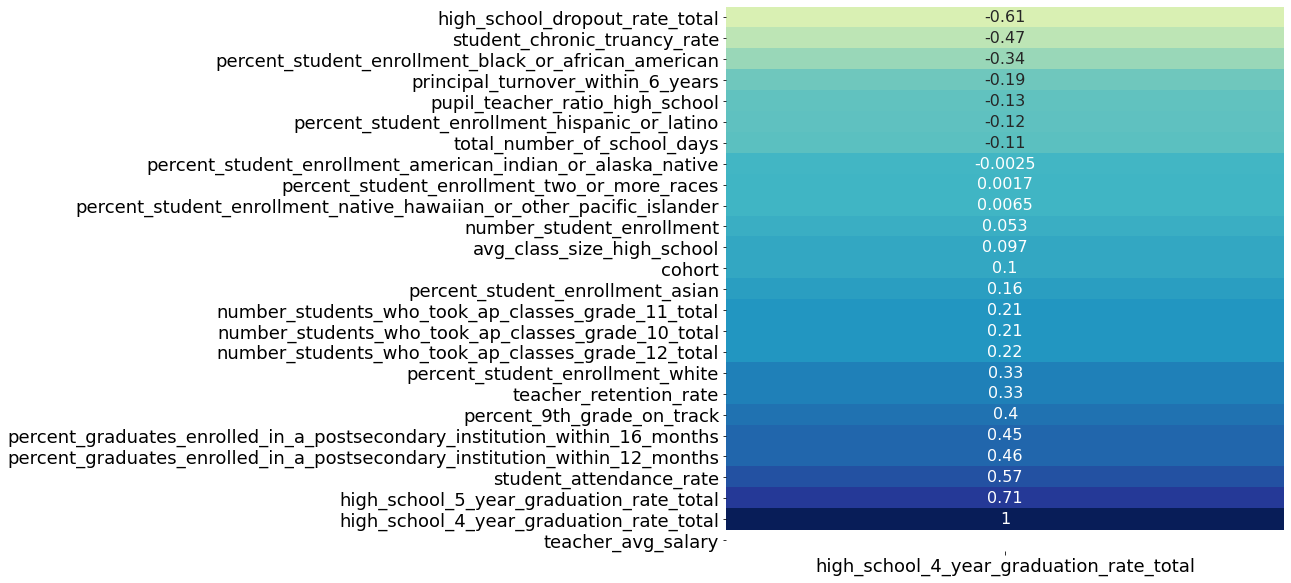

In [54]:
heatmap_numeric_w_dependent_variable(merged_df, 'high_school_4_year_graduation_rate_total')
plt.savefig('figures/heatmap.png')
plt.show();

In [55]:
outcome = 'high_school_4_year_graduation_rate_total'
predictors = merged_df.drop('high_school_4_year_graduation_rate_total', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=merged_df).fit()
model.summary()

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X = merged_df.drop("high_school_4_year_graduation_rate_total", axis=1)
y = merged_df["high_school_4_year_graduation_rate_total"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)